# GANs (Generative Adversarial Networks)

En este laboratorio 5 vamos a trabajar con GANs (Generative Adversarial Networks). Las GANs son un tipo de arquitectura de redes neuronales que se utilizan para generar datos nuevos a partir de un conjunto de datos de entrenamiento. Las GANs se componen de dos redes neuronales, un generador y un discriminador. El generador es el encargado de generar datos nuevos a partir de un conjunto de datos de entrenamiento. El discriminador es el encargado de distinguir entre datos reales y datos generados por el generador. El objetivo de las GANs es entrenar al generador para que genere datos que el discriminador no pueda distinguir de los datos reales.


In [50]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

# Device configuration (GPU o CPU)
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Dataset

Usaremos el dataset fer2013, que contiene imágenes de caras de personas con diferentes expresiones faciales. El dataset se puede descargar de Kaggle: https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data 

In [55]:
# Ruta donde se almacenarán los datos FER2013 (ajústala a tu directorio deseado)
root = 'datasets/fer-2013/train/'

# Transformaciones de datos
transform = transforms.Compose([
        # transformar a escala de grises
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
    ])

# Cargar datos de entrenamiento
train_dataset = ImageFolder(root=root, transform=transform)

# clases del dataset fer2013
classes = ('Angry', 'Disgust', 'Fear', 'Happy', 'Neutral' , 'Sad', 'Surprise')

In [56]:
import numpy as np

class Dataset(torch.utils.data.Dataset):
    def __init__(self, trainset):
        self.imgs = torch.tensor([np.array(i[0]).flatten() / 1 for i in trainset], dtype=torch.float, device=device)
        self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, ix):
        return self.imgs[ix], self.labels[ix]

train = Dataset(train_dataset)
len(train)

28709

In [57]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

(torch.Size([2304]),
 torch.float32,
 tensor(0.7725, device='cuda:0'),
 tensor(0.0118, device='cuda:0'))

In [58]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

(torch.Size([32, 2304]), torch.Size([32]))

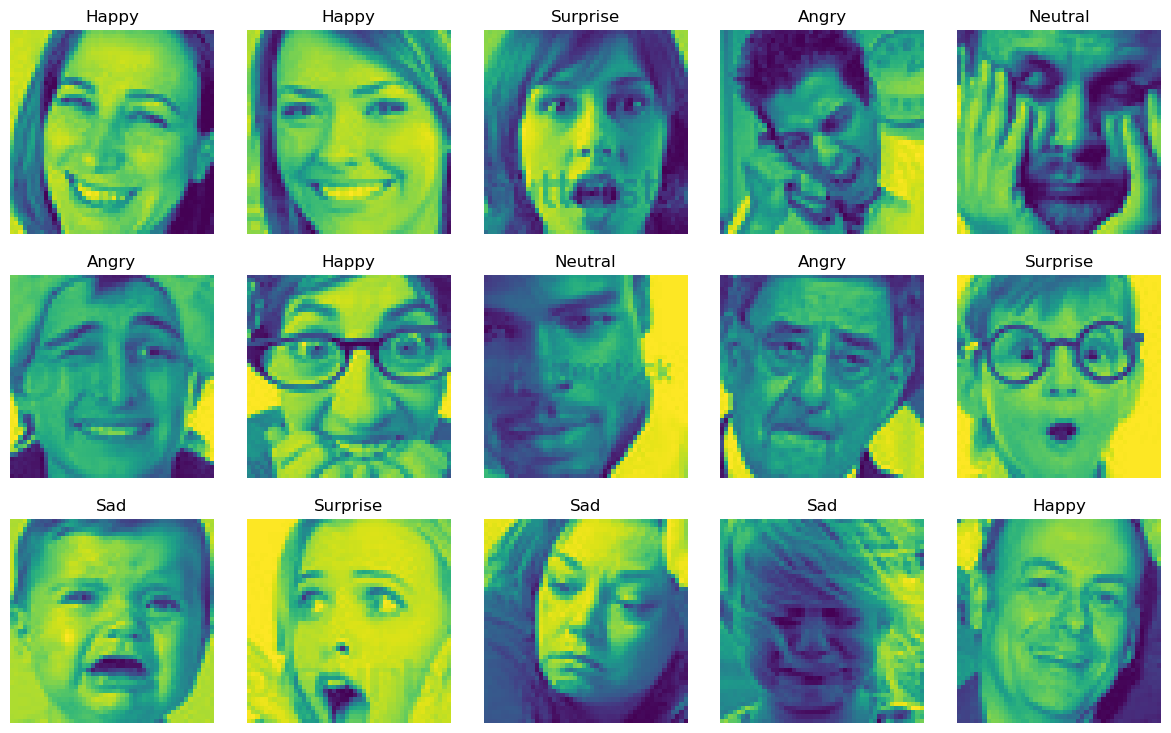

In [59]:
import random
import matplotlib.pyplot as plt

r, c = 3, 5
plt.figure(figsize=(c * 3, r * 3))
for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(train) - 1)
        img, label = train[ix]
        plt.imshow(img.reshape(48, 48).cpu())
        plt.axis("off")
        plt.title(classes[label.item()])
plt.subplots_adjust(wspace=0.1, hspace=0.2)
plt.show()

In [60]:
import torch.nn as nn

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 128 * 12 * 12),
            nn.BatchNorm1d(128 * 12 * 12),
        )
        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 1, 4, stride=2, padding=1, bias=False),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 128, 12, 12)
        x = self.main(x)
        x = x.view(x.size(0), 48 * 48)
        return x

In [61]:
generator = Generator()
output = generator(torch.randn(64, 100))
output.shape

torch.Size([64, 2304])

In [62]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(1, 64, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
        )
        self.out = nn.Sequential(
            nn.Linear(128 * 12 * 12, 1),  # Cambio el tamaño de entrada
            nn.Sigmoid()
        )

    def forward(self, x):
        x = x.view(x.size(0), 1, 48, 48)  # Cambio el tamaño de entrada
        x = self.main(x)
        x = x.view(x.size(0), -1)
        x = self.out(x)
        return x

In [63]:
discriminator = Discriminator()
output = discriminator(torch.randn(64, 48 * 48))
output.shape

torch.Size([64, 1])

In [64]:
from tqdm import tqdm

def fit(g, d, dataloader, epochs=30, crit=None):
    g.to(device)
    d.to(device)
    g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)
    d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)
    crit = nn.BCEWithLogitsLoss() if crit is None else crit
    g_loss, d_loss = [], []
    
    hist = {'g_loss': [], 'd_loss': []}
    
    for epoch in range(1, epochs + 1):
        g_losses = []
        d_losses = []
        
        with tqdm(total=len(dataloader), desc=f'Epoch {epoch}/{epochs}', unit='batch') as pbar:
            for X, y in dataloader:
                g.eval()
                d.train()
                
                noise = torch.randn((X.size(0), g.input_size)).to(device)
                generated_images = g(noise)
                
                d_input = torch.cat([generated_images, X.view(X.size(0), -1)])
                d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1, 1).to(device)
                
                d_optimizer.zero_grad()
                d_output = d(d_input)
                d_loss_value = crit(d_output, d_gt)
                d_loss_value.backward()
                d_optimizer.step()
                d_losses.append(d_loss_value.item())
                
                g.train()
                d.eval()
                
                noise = torch.randn((X.size(0), g.input_size)).to(device)
                generated_images = g(noise)
                
                d_output = d(generated_images)
                g_gt = torch.ones(X.size(0)).view(-1, 1).to(device)
                
                g_optimizer.zero_grad()
                g_loss_value = crit(d_output, g_gt)
                g_loss_value.backward()
                g_optimizer.step()
                g_losses.append(g_loss_value.item())
                
                pbar.set_postfix(g_loss=np.mean(g_losses), d_loss=np.mean(d_losses))
                pbar.update()
                
        hist['g_loss'].append(np.mean(g_losses))
        hist['d_loss'].append(np.mean(d_losses))
    
    return hist

In [68]:
hist = fit(generator, discriminator, dataloader, epochs=20, crit=torch.nn.BCELoss())

Epoch 20/20: 100%|██████████| 898/898 [00:11<00:00, 80.91batch/s, d_loss=0.154, g_loss=3.64]


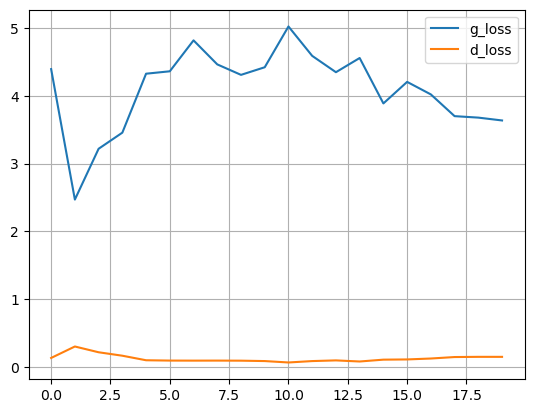

In [69]:
import pandas as pd

df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

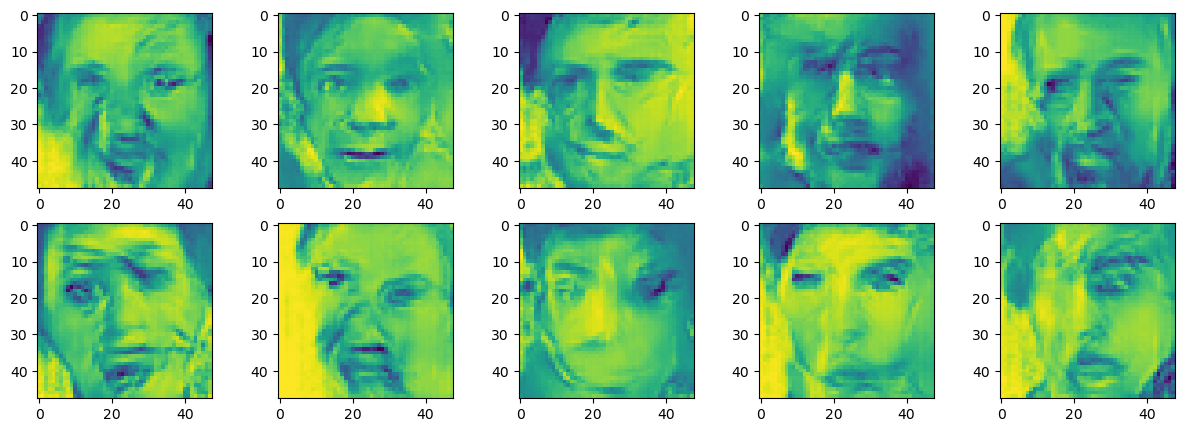

In [70]:
generator.eval()
with torch.no_grad():
    noise = torch.randn((10, generator.input_size)).to(device)
    generated_images = generator(noise)
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    i = 0
    for ax in axs:
        for _ax in ax:
            img = generated_images[i].view(48, 48).cpu()
            _ax.imshow(img)
            i += 1
    plt.show()